### Notation
Capital leters denote random variables $X$ and lower-case denotes observations $x$;

Capital $P(X)$ denotes the true probablity distribution and $P(x)$ is short-hand for $P(X=x)$;

We use lower case $p$ to denote approximations/models of probability distributions $p(x)$.


# Deep latent variable generative models

Generative modelling aims to model the data distribution from an observed sample. Formally, given a set of observations (sample) $\{x^{(1)}, \ldots, x^{(n)}\}$ of random variable $X$ distributed according to an unknown distribution $X \sim P(X)$, we wish to obtain a parametric probabilistic model $p_\theta$ from which we can generate new samples for distribution and calculate densities $p_\theta(X=x)$.

When the observed variable is high-dimensional and has a complex structure, simple parametric or linear models are not powerful enough.
Latent variable generative models allow us to represent complex, high-dimensional data distributions through a lower-dimensional, simpler structure. Specifically, we assume that the variation in the observed random variable $X$ is governed by a set of underlying, unobservable latent variables $Z$, which is related to $X$ via a conditional model $P(X \vert Z)$.
We usually choose $Z \sim P(Z)$ to be a simple parametric distribution, such as a normal distribution, and thus the goal is to model $p_\theta(x \vert z)$.

The advantage of this approach is that it provides a compact representation of the complex data distribution, which can be useful for tasks such as data visualization, density estimation, and data synthesis. Additionally, by learning a lower-dimensional representation of the data, latent variable generative models can also capture meaningful patterns and relationships in the data, which can be leveraged for a variety of downstream tasks such as classification, clustering, and generative art.

Usually, the first step in any generative model is to write down the log-likelihood of $X$ as the marginal distribution over latent factors and then use Bayes rule to obtain a conditional model, resulting in the log-expectation over the latent variable.

$\begin{aligned} \log p(x) &= \log \int p(x, z) dz \\ &= \log \int p(x \vert z)p(z) dz\\ &= \log \mathbb{E}_{z \sim p(z)}\big[p(x \vert z)\big] \end{aligned}$

$p(\mathbf{x}) = \prod_{i=1}^N p(x_i)$


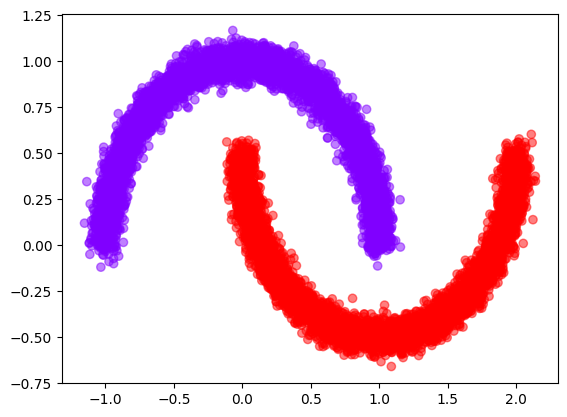

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as datasets
import torch
from torch.utils.data import DataLoader, Dataset, random_split

class MoonsDataset(Dataset):
    def __init__(self, n_samples=10000, noise=0.01):
        X, y = datasets.make_moons(n_samples=n_samples, noise=noise)
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray)

        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


ds = MoonsDataset(noise=.05)
n_train, n_val, n_test = 6000, 2000, 2000
train_ds, val_ds, test_ds = random_split(ds, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

plt.scatter(ds.X[:, 0], ds.X[:, 1], c=ds.y, cmap="rainbow", alpha=0.5)
plt.show()

## Monte-Carlo Expectation Maximisation

The Monte-Carlo approximation of the integral is given by:

$\begin{aligned} \log p(x) &= \log \int p(x, z) dz \\ &= \log \int p(x \vert z)p(z) dz\\ &= \log \mathbb{E}_{z \sim p(z)}\big[p(x \vert z)\big] \\ &\approx \log \frac{1}{M}\sum_{m=1}^{M}p(x \vert z_m), \quad z_m \sim p(z)\end{aligned}$

We can obtain an algorithm by selecting parametric forms for the latent prior $p(z)$ and likelihood $p(x \vert z)$.

For example, we can choose the latent prior to be a standard Gaussian: $p(z) \sim \mathcal{N}(0, 1)$ and the likelihood to be a Gaussian distribution with mean and variance parameterised by a neural network: $p(x \vert z) \sim \mathcal{N}(\mu_\theta(z), \sigma^2_\theta(z))$.

Using MAP estimation for the model's parameters, we obtain the following objective:

$\theta^* = \begin{aligned}\arg \max_{\theta}\frac{1}{N}\sum_{n=1}^N\log  \frac{1}{M}\sum_{m=1}^M p_\theta(x^{(n)} \vert z^{(m)}) \quad z^{(m)} \sim p(z)\end{aligned}$

We can obtain parameter estimates by using expectation maximisation/mini-batch gradient descent. The loss function is the negative log-likelihood.

4999/5000: Loss 0.844: : 5000it [02:26, 34.11it/s]
/tmp/ipykernel_7141/263069535.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)


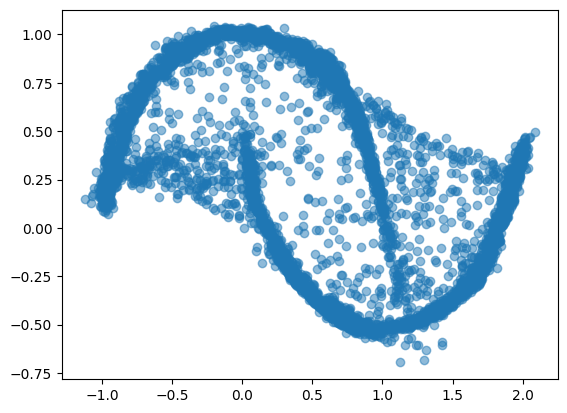

In [83]:
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import torch
import torch.optim
from functorch import vmap
from itertools import cycle
from tqdm import tqdm
from torch.distributions import Normal, Independent
import math

class MCEM(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.prior = Independent(
            Normal(loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim)), 1
        )

        self.generative_model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=input_dim * 2),
        )

    def sample(self, num_samples: int) -> torch.Tensor:
        z = self.prior.sample(torch.Size((num_samples,)))
        x_mean, x_logvar = torch.split(
            self.generative_model(z), split_size_or_sections=2, dim=-1
        )
        # likelihood_dist = Independent(
        #     Normal(loc=x_mean, scale=torch.exp(0.5 * x_logvar)), 1
        # )
        likelihood_dist = torch.distributions.MultivariateNormal(
            loc=x_mean, covariance_matrix=torch.diag_embed(torch.exp(0.5 * x_logvar)))
        return likelihood_dist.sample()

    def loss(self, x: torch.Tensor, num_mc_samples: int = 100) -> torch.Tensor:
        z = self.prior.sample(torch.Size((num_mc_samples, x.shape[0])))
        x_mean, x_logvar = torch.split(
            vmap(self.generative_model)(z), split_size_or_sections=2, dim=-1
        )

        likelihood_dist = Independent(
            Normal(loc=x_mean, scale=torch.exp(0.5 * x_logvar)), 1
        )

        likelihood_dist = torch.distributions.MultivariateNormal(
            loc=x_mean, covariance_matrix=torch.diag_embed(torch.exp(0.5 * x_logvar)))
        # 1/M sum_{m=1}^{M} p(x_n \vert z_m)
        # likelihood = torch.logsumexp(likelihood_dist.log_prob(x), dim=0) - math.log(num_mc_samples)
        likelihood = torch.log(
            torch.mean(torch.exp(likelihood_dist.log_prob(x)), dim=0)
        )
        # loss is negative log averaged over sample points
        loss = -torch.mean(likelihood)
        return loss

    def forward(self, num_samples: int) -> torch.Tensor:
        return self.sample(num_samples)


model = MCEM(input_dim=2, hidden_dim=32, latent_dim=8)
num_steps = 5000
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

pbar = tqdm(zip(range(num_steps), cycle(train_loader)))

for step, (x, y) in pbar:
    optimizer.zero_grad()
    loss = model.loss(x, num_mc_samples=100)
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{step:03d}/{num_steps:03d}: Loss {loss:.3f}")


samples = model(5000).detach().numpy()
plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)

# Next sessions after this, code and theory are still not clean, please ignore

## Variational Auto-Encoder (VAE)

References:

- [Variational Inference: A Review for Statisticians](https://arxiv.org/abs/1601.00670)

- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) (VAEs)

- [Variational Bayesian Inference with Stochastic Search](https://arxiv.org/abs/1206.6430)

- Lectures on variational inference: [Zoubin Ghahramani](https://www.youtube.com/watch?v=eZR_x9bKIcQ) and [David Blei](https://www.youtube.com/watch?v=ogdv_6dbvVQ)


gradient estimators https://arxiv.org/abs/1506.05254 score function gradient and REINFORCE and likelihood ratio are the same thing
reparameetreoisatio trick same as pathwise deritivative

In the previous model, we learnt the generative model $p(x \vert z)$, but we did not perform inference on $z$, meaning we did not estimate $p(z \vert x)$. Inferring the latent variable is useful for dimensionality reduction, explainability, disentanglement, and controlling the generative process. To that end, we use the **Bayesian learning** framework to relate the different densities of interest:

$\begin{aligned} \overbrace{p(z \vert x)}^{\text{posterior}} = \frac{\overbrace{p(x \vert z)}^{\text{likelihood}}\overbrace{p(z)}^{\text{prior}}}{\underbrace{p(x)}_{\text{evidence}}} \quad \text{where} \quad p(x) = \int p(x, z) dz\end{aligned}$

For many problems, there is no closed-form solution for the posterior, and thus inference on $z$ is intractable. For example, if the likelihood $p(x \vert z)$ is moderately complex (e.g. a 2 layer neural network), the evidence (aka marginal likelihood) $p(x) = \int p(x \vert z) p(z) dz$ becomes intractable. For these problems, we must resort to approximate inference techniques such as **variational inference**.

**Variational Inference** (VI) is a method for approximating intractable integrals by introducing an auxiliary variational distribution.
The method involves choosing a "variational family" of simple distributions $q_\phi(z) \in \mathcal{Q}$, and via optimisation, selecting the member of this family that is closest to the true posterior $p(z \vert x)$. Thus the true posterior is approximated as $p(z \vert x) \approx q_\phi(z)$. 
The similarity between the true posterior and the variational distribution measures the quality of the approximation.

The Variational Auto-Encoder (VAE) is a generative model which uses variational inference to approximate the evidence integral $p(x)$. 
To obtain a tractable algorithm, we make the following assumptions:
- The likelihood is a parametric distribution parameterised by a neural network decoder $p_\theta(x \vert z)$. This choice makes inference intractable but gives us a flexible and powerful generative model. 
- The prior is a simple known distribution (e.g. isotropic normal distribution). 
- The variational family is a set parametric conditional distributions parameterised by a neural network encoder $q_\phi(z \vert x)$ such that $p(z \vert x) \approx q_\phi(z \vert x)$.

Using variational inference and Jensen's inequality, we obtain the Evidence Lower Bound (ELBO). As the name indicates, the ELBO is a lower bound for the evidence: $p(x) \geq ELBO$, and thus maximising the ELBO also maximises the evidence. The ELBO can be derived as follows:

$\begin{aligned} \log p(x) &= \log \int p(x, z) dz \\ &= \log \int p(x, z) \frac{q_\phi(z \vert x)}{q_\phi(z \vert x)} dz \\&= \log \mathbb{E}_{q_\phi(z \vert x)}\Bigg[\frac{p(x, z)}{q_\phi(z \vert x)}\Bigg] \\ &= \log \mathbb{E}_{q_\phi(z \vert x)}\Bigg[\frac{p_\theta(x \vert z)p(z)}{q_\phi(z \vert x)}\Bigg] \\ &\geq \mathbb{E}_{q_\phi(z \vert x)}\Bigg[\log\frac{p_\theta(x \vert z)p(z)}{q_\phi(z \vert x)}\Bigg] & \text{(via Jensen's inequality)} \\&= \underbrace{\mathbb{E}_{q_\phi(z \vert x)}\Bigg[\log p_\theta(x \vert z)\Bigg]}_\text{likelihood} - \underbrace{\mathbb{E}_{q_\phi(z \vert x)}\Bigg[\log \frac{q_\phi(z \vert x)}{p(z)} \Bigg]}_{D_{KL}(q_\phi(z \vert x) \Vert p(z))} = ELBO(\theta, \phi) \end{aligned}$

The ELBO comprises two terms: a likelihood term and the KL divergence term. Maximising the ELBO results in the following optimisation problem.
$(\theta^*, \phi^*) = \arg \max_{\theta, \phi} ELBO(\theta\ \phi)$

To obtain estimator for the parameters we take the gradient with respect to said parameters:

$\nabla_\theta ELBO(\theta, \phi) ={\mathbb{E}_{q_\phi(z \vert x)}\Bigg[ \nabla_\theta \log p_\theta(x \vert z)\Bigg]}$ 

and

$\nabla_\phi ELBO(\theta, \phi) =\underbrace{\nabla_\phi{\mathbb{E}_{q_\phi(z \vert x)}\Bigg[\log p_\theta(x \vert z)\Bigg]}}_{\text{likelihood grad}} + \underbrace{\nabla_\phi D_{KL}(q_\phi(z \vert x) \Vert p(z))}_{\text{KL grad}}$ 

If both the approximate posterior $q_\phi(z \vert x)$ and the prior $p(z)$ are Gaussian, we can compute the KL divergence and its gradient in closed form. 

The naive Monte Carlo gradient estimator for the likelihood is $\nabla_\phi{\mathbb{E}_{q_\phi(z \vert x)}\bigg[\log p_\theta(x \vert z)\bigg]} = \mathbb{E}_{q_\phi(z \vert x)}$
is:


Reparameterisation trick





4999/5000: Loss 1.436: : 5000it [00:34, 146.71it/s]
/tmp/ipykernel_7141/2151726616.py:101: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)


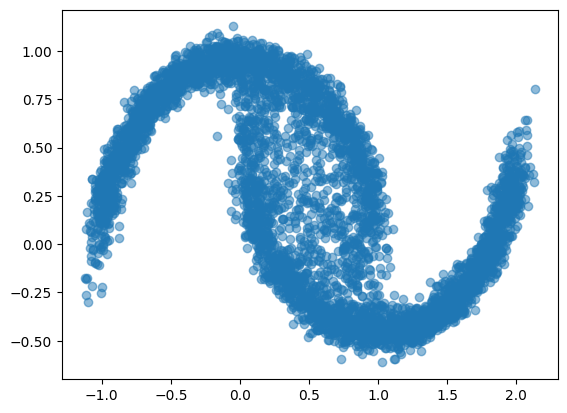

In [78]:
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import torch
import torch.optim
from functorch import vmap
from itertools import cycle
from tqdm import tqdm
from typing import Tuple, Dict
import math

class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        self.prior = torch.distributions.MultivariateNormal(
            loc=torch.zeros((latent_dim,)),
            covariance_matrix=torch.diag_embed(torch.ones((latent_dim,))),
        )

        self.inference_model = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=latent_dim * 2),
        )

        self.generative_model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=input_dim * 2),
        )

    def sample(self, num_samples: int) -> torch.Tensor:
        z = self.prior.sample(torch.Size((num_samples,)))
        x_mean, x_logvar = torch.split(
            self.generative_model(z), split_size_or_sections=2, dim=-1
        )
        # likelihood_dist = torch.distributions.MultivariateNormal(
        #     loc=x_mean, covariance_matrix=torch.diag_embed(torch.exp(.5 * x_logvar)))
        likelihood_dist = torch.distributions.MultivariateNormal(
            loc=x_mean, covariance_matrix=torch.diag_embed(.05 * torch.ones_like(x_mean)))
        likelihood_dist = torch.distributions.Independent(torch.distributions.Normal(loc=x_mean, scale=.05 * torch.ones_like(x_mean)), reinterpreted_batch_ndims=1)
        return likelihood_dist.sample()

    def loss(
        self, x: torch.Tensor, num_mc_samples: int = 100
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        out = self.inference_model(x)
        mu, log_var = out[:, : self.latent_dim], out[:, self.latent_dim :]
        posterior = torch.distributions.MultivariateNormal(
            loc=mu, covariance_matrix=torch.diag_embed(torch.exp(.5 * log_var))
        )
        z = posterior.rsample(torch.Size((num_mc_samples,)))
        x_mean, x_logvar = torch.split(
            vmap(self.generative_model)(z), split_size_or_sections=2, dim=-1
        )
        # compute loss
        kl = torch.distributions.kl_divergence(posterior, self.prior)
        # likelihood_dist = torch.distributions.MultivariateNormal(
        #     loc=x_mean, covariance_matrix=.05 * torch.eye(x_mean.shape[-1]))
        
        # likelihood_dist = torch.distributions.MultivariateNormal(
        #     loc=x_mean, covariance_matrix=torch.diag_embed(torch.exp(.5 * x_logvar)))
        likelihood_dist = torch.distributions.MultivariateNormal(
            loc=x_mean, covariance_matrix=torch.diag_embed(.05 * torch.ones_like(x_mean)))
        
        #likelihood_dist = torch.distributions.Independent(torch.distributions.Normal(loc=x_mean, scale=.05 * torch.ones_like(x_mean)), reinterpreted_batch_ndims=1)

        log_likelihood = torch.mean(likelihood_dist.log_prob(x), dim=0)
        elbo = log_likelihood - kl
        loss = -torch.mean(elbo)# + torch.mean(torch.exp(.5 * x_logvar))
        return loss, {
            "elbo": -loss,
            "likelihood": torch.mean(log_likelihood),
            "kl": torch.mean(kl),
        }

    def forward(self, num_samples: int) -> torch.Tensor:
        return self.sample(num_samples)


model = VAE(input_dim=2, hidden_dim=32, latent_dim=2)
num_steps = 5000
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

pbar = tqdm(zip(range(num_steps), cycle(train_loader)))

for step, (x, y) in pbar:
    optimizer.zero_grad()
    loss, output = model.loss(x, num_mc_samples=10)
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{step:03d}/{num_steps:03d}: Loss {loss:.3f}")


samples = model(5000).detach().numpy()
plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)

## Normalising Flows
https://github.com/VincentStimper/normalizing-flows


4999/5000: Loss -6.639: : 5000it [01:00, 82.39it/s]
/tmp/ipykernel_7141/2893965634.py:133: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)


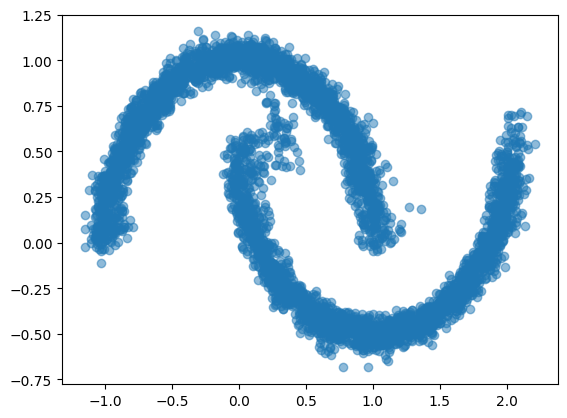

In [58]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch.distributions
import torch
import torch.optim
from tqdm import tqdm
from typing import Tuple
from functorch import vmap
from abc import ABC
import torch.nn.functional as F


class Bijection(ABC, nn.Module):
    def __init__(self) -> None:
        super().__init__()

    # must return y and log_det
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        ...

    # must return x
    def inverse(self, y: torch.Tensor) -> torch.Tensor:
        ...


class Flip(Bijection):
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.dim = dim

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        y = torch.cat((x[:, self.dim // 2 :], x[:, : self.dim // 2]), dim=-1)
        log_det = torch.ones(size=(x.shape[0],))
        return y, log_det

    def inverse(self, y: torch.Tensor) -> torch.Tensor:
        return torch.cat((y[:, self.dim // 2 :], y[:, : self.dim // 2]), dim=-1)


class AffineCoupling(Bijection):
    def __init__(self, dim: int, hidden_dim: int = 32) -> None:
        super().__init__()
        self.d = dim // 2
        self.dim = dim
        self.network = nn.Sequential(
            nn.Linear(in_features=self.d, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=(dim - self.d) * 2),
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        y1 = x[:, : self.d]
        log_scale, shift = torch.split(
            self.network(x[:, : self.d]), split_size_or_sections=self.dim // 2, dim=-1
        )
        log_scale = torch.tanh(log_scale)
        y2 = x[:, self.d :] * torch.exp(log_scale) + shift
        y = torch.cat((y1, y2), dim=-1)
        log_det = torch.sum(log_scale, dim=-1)
        return y, log_det

    def inverse(self, y: torch.Tensor) -> torch.Tensor:
        x1 = y[:, : self.d]
        log_scale, shift = torch.split(
            self.network(y[:, : self.d]), split_size_or_sections=self.dim // 2, dim=-1
        )
        log_scale = torch.tanh(log_scale)
        x2 = (y[:, self.d :] - shift) * torch.exp(-log_scale)
        return torch.cat((x1, x2), dim=-1)


class RealNVP(nn.Module):
    def __init__(self, input_dim: int) -> None:
        super().__init__()
        self.prior = torch.distributions.MultivariateNormal(
            loc=torch.zeros(input_dim),
            covariance_matrix=torch.eye(input_dim),
        )
        self.bijections = nn.ModuleList(
            [
                AffineCoupling(input_dim),
                Flip(input_dim),
                AffineCoupling(input_dim),
                Flip(input_dim),
                AffineCoupling(input_dim),
                Flip(input_dim),
                AffineCoupling(input_dim),
                Flip(input_dim),
                AffineCoupling(input_dim),
                Flip(input_dim),
                AffineCoupling(input_dim),
                Flip(input_dim),
                AffineCoupling(input_dim),
                Flip(input_dim),
                AffineCoupling(input_dim),
            ]
        )

    def sample(self, num_samples: int) -> torch.Tensor:
        z = self.prior.sample(torch.Size((num_samples,)))
        for bijection in self.bijections[::-1]:
            z = bijection.inverse(z)
        return z

    def loss(self, x: torch.Tensor) -> torch.Tensor:
        loglikelihood = 0
        for bijection in self.bijections:
            x, log_det = bijection.forward(x)
            loglikelihood += log_det
        loss = -torch.mean(loglikelihood + self.prior.log_prob(x))
        return loss


model = RealNVP(input_dim=2)
num_steps = 5000
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

pbar = tqdm(zip(range(num_steps), cycle(train_loader)))

for step, (x, y) in pbar:
    optimizer.zero_grad()
    loss = model.loss(x)
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{step:03d}/{num_steps:03d}: Loss {loss:.3f}")

samples = model.sample(5000).detach().numpy()
plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)

## GAN

59999/60000: Loss 1.386: : 60000it [06:08, 162.85it/s]
/tmp/ipykernel_16569/763234823.py:66: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)


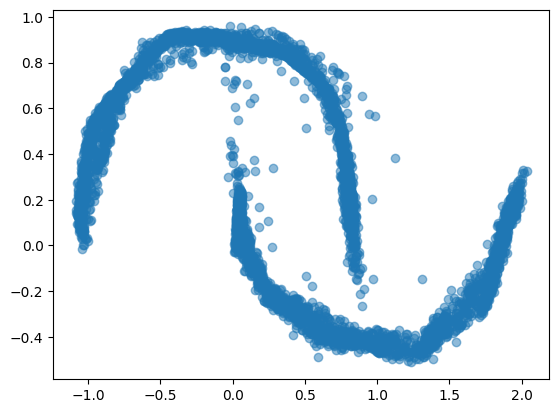

In [35]:
import torch.nn as nn
import torch.distributions
import torch.optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

class GAN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, z_dim: int) -> None:
        super().__init__()

        self.p_z = torch.distributions.Normal(loc=torch.zeros(z_dim), scale=torch.ones(z_dim))
        self.generator = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=input_dim)
        )

        self.discriminator = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_dim, out_features=1), 
            nn.Sigmoid()
        )

    def sample(self, num_samples: int) -> torch.Tensor:
        z = self.p_z.sample(torch.Size((num_samples,)))
        return self.generator(z)

    def disc_loss(self, x: torch.Tensor) -> torch.Tensor:
        z = self.p_z.sample((x.shape[0],))
        return -(torch.mean(torch.log(self.discriminator(x))) + torch.mean(torch.log(1 - self.discriminator(self.generator(z)))))


    def gen_loss(self, x: torch.Tensor) -> torch.Tensor:
        z = self.p_z.sample((x.shape[0],))
        return  torch.mean(torch.log(1 - self.discriminator(self.generator(z))))


model = GAN(2, 16, 8)
num_steps = 60000
disc_opt = torch.optim.Adam(model.discriminator.parameters(), lr=1e-3)
gen_opt = torch.optim.Adam(model.generator.parameters(), lr=1e-3)
pbar = tqdm(zip(range(num_steps), cycle(train_loader)))

for step, (x, y) in pbar:
    disc_opt.zero_grad()
    gen_opt.zero_grad()
    gen_loss = model.gen_loss(x)
    gen_loss.backward()
    gen_opt.step()

    disc_opt.zero_grad()
    gen_opt.zero_grad()
    disc_loss = model.disc_loss(x)
    disc_loss.backward()
    disc_opt.step()

    pbar.set_description(f"{step:03d}/{num_steps:03d}: Loss {disc_loss:.3f}")

samples = model.sample(5000).detach().numpy()
plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)

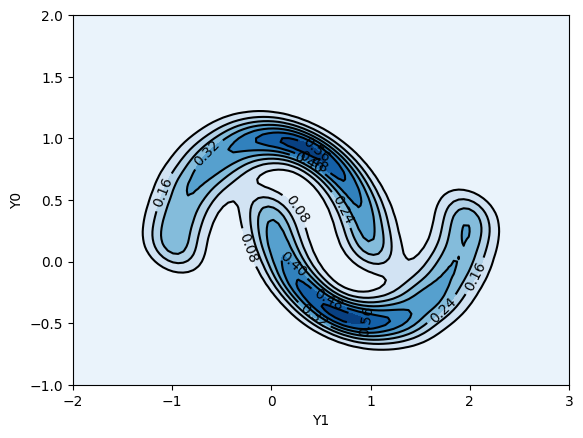

/tmp/ipykernel_7141/3868418894.py:68: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)


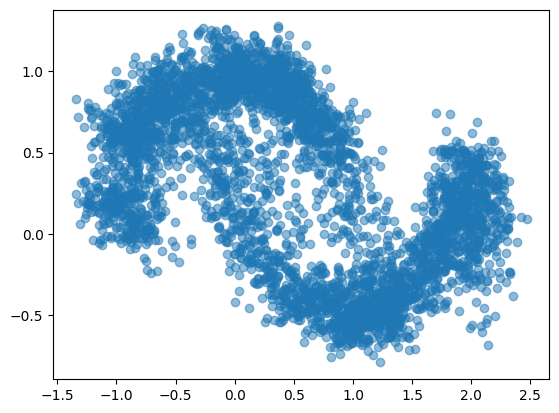

In [3]:
import torch.distributions
import torch
import torch.optim
import scipy.stats as st
from numpy.typing import NDArray

# Kernel density estimation of the target density
def get_kde(data: NDArray):
    xmin, xmax = -2, 3
    ymin, ymax = -1, 2

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    kde_score_fn = st.gaussian_kde(data.T)
    f = np.reshape(kde_score_fn(positions).T, xx.shape)

    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    # Contourf plot
    cfset = ax.contourf(xx, yy, f, cmap="Blues")
    ## Or kernel density estimate plot instead of the contourf plot
    # ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    cset = ax.contour(xx, yy, f, colors="k")
    # Label plot
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel("Y1")
    ax.set_ylabel("Y0")
    plt.show()
    return kde_score_fn


def metropolis_hastings(
    dim: int, x: torch.Tensor, num_samples: int, burnin: float = 0.2
):
    kde_score_fn = get_kde(x.detach().numpy())
    u = torch.distributions.Uniform(low=0.0, high=1.0)
    proposal_density = torch.distributions.MultivariateNormal(
        loc=torch.zeros(dim),
        covariance_matrix=0.01 * torch.diag_embed(torch.ones((dim,))),
    )

    def f(c: torch.Tensor):
        return torch.tensor(kde_score_fn(c[: np.newaxis]))

    samples = [0.5 * torch.ones((dim,))]
    while len(samples) < num_samples:
        candidate = proposal_density.sample() + samples[-1]
        alpha = f(candidate) / f(samples[-1])
        if u.sample() <= alpha:
            samples.append(candidate)

    return torch.stack(samples[int(burnin * len(samples)) :], dim=0)


samples = metropolis_hastings(2, ds.X, 5000)
plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)